In [2]:
# Cell 1: Import libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

In [4]:
# Cell 2: Obtain data
df = pd.read_csv('/content/cardio_train.csv', sep=';')
df.head()
df.info()
df.describe().T
df.cardio.value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


,proportion
cardio,
0,0.5003
1,0.4997


In [5]:
# Cell 3: Scrub — initial checks
df.isna().sum()
df.duplicated().sum()
df.drop('id', axis=1, inplace=True)
df['gender'].replace(2, 0, inplace=True)
df['age'] = round(df['age'] / 365, 1)
print(df.age.min(), df.age.max())


29.6 65.0


In [6]:
# Cell 4: Scrub — clean height-related outliers
df[df['height'] < 125]
df = df[df['height'] >= 125]
df[df['height'] > 200]
df.drop(index=6486, inplace=True)


In [7]:
# Cell 5: Scrub — clean blood pressure anomalies
df = df[df['ap_hi'] > df['ap_lo']]
df = df[df['ap_hi'] > 80]
df = df[df['ap_lo'] > 50]
df = df[df['ap_hi'] < 250]
df[df['ap_lo'] > 150]


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
4781,51.9,1,158,74.0,200,170,1,1,0,0,1,1
4981,62.3,0,173,74.0,220,160,2,2,0,0,1,1
38022,59.6,1,161,84.0,196,182,2,2,0,0,1,1
43998,62.1,0,163,70.0,200,180,1,1,0,0,0,1
54987,53.4,1,169,80.0,200,160,3,3,0,0,1,0


In [9]:
# Cell 6: Scrub — clean weight and rename columns
df = df[df['weight'] >= 40]
df.reset_index(inplace=True, drop=True)
new_names = {'ap_hi':'systolic','ap_lo':'diastolic','gluc':'glucose','alco':'alcohol','cardio':'disease'}
df = df.rename(columns=new_names)
df.shape
df.disease.value_counts(normalize=True)


,proportion
disease,
0,0.504729
1,0.495271


array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='gender', ylabel='age'>,
        <Axes: xlabel='height', ylabel='age'>,
        <Axes: xlabel='weight', ylabel='age'>,
        <Axes: xlabel='systolic', ylabel='age'>,
        <Axes: xlabel='diastolic', ylabel='age'>,
        <Axes: xlabel='cholesterol', ylabel='age'>,
        <Axes: xlabel='glucose', ylabel='age'>,
        <Axes: xlabel='smoke', ylabel='age'>,
        <Axes: xlabel='alcohol', ylabel='age'>,
        <Axes: xlabel='active', ylabel='age'>,
        <Axes: xlabel='disease', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='gender'>,
        <Axes: xlabel='gender', ylabel='gender'>,
        <Axes: xlabel='height', ylabel='gender'>,
        <Axes: xlabel='weight', ylabel='gender'>,
        <Axes: xlabel='systolic', ylabel='gender'>,
        <Axes: xlabel='diastolic', ylabel='gender'>,
        <Axes: xlabel='cholesterol', ylabel='gender'>,
        <Axes: xlabel='glucose', ylabel='gender'>,
        <Axes: xla

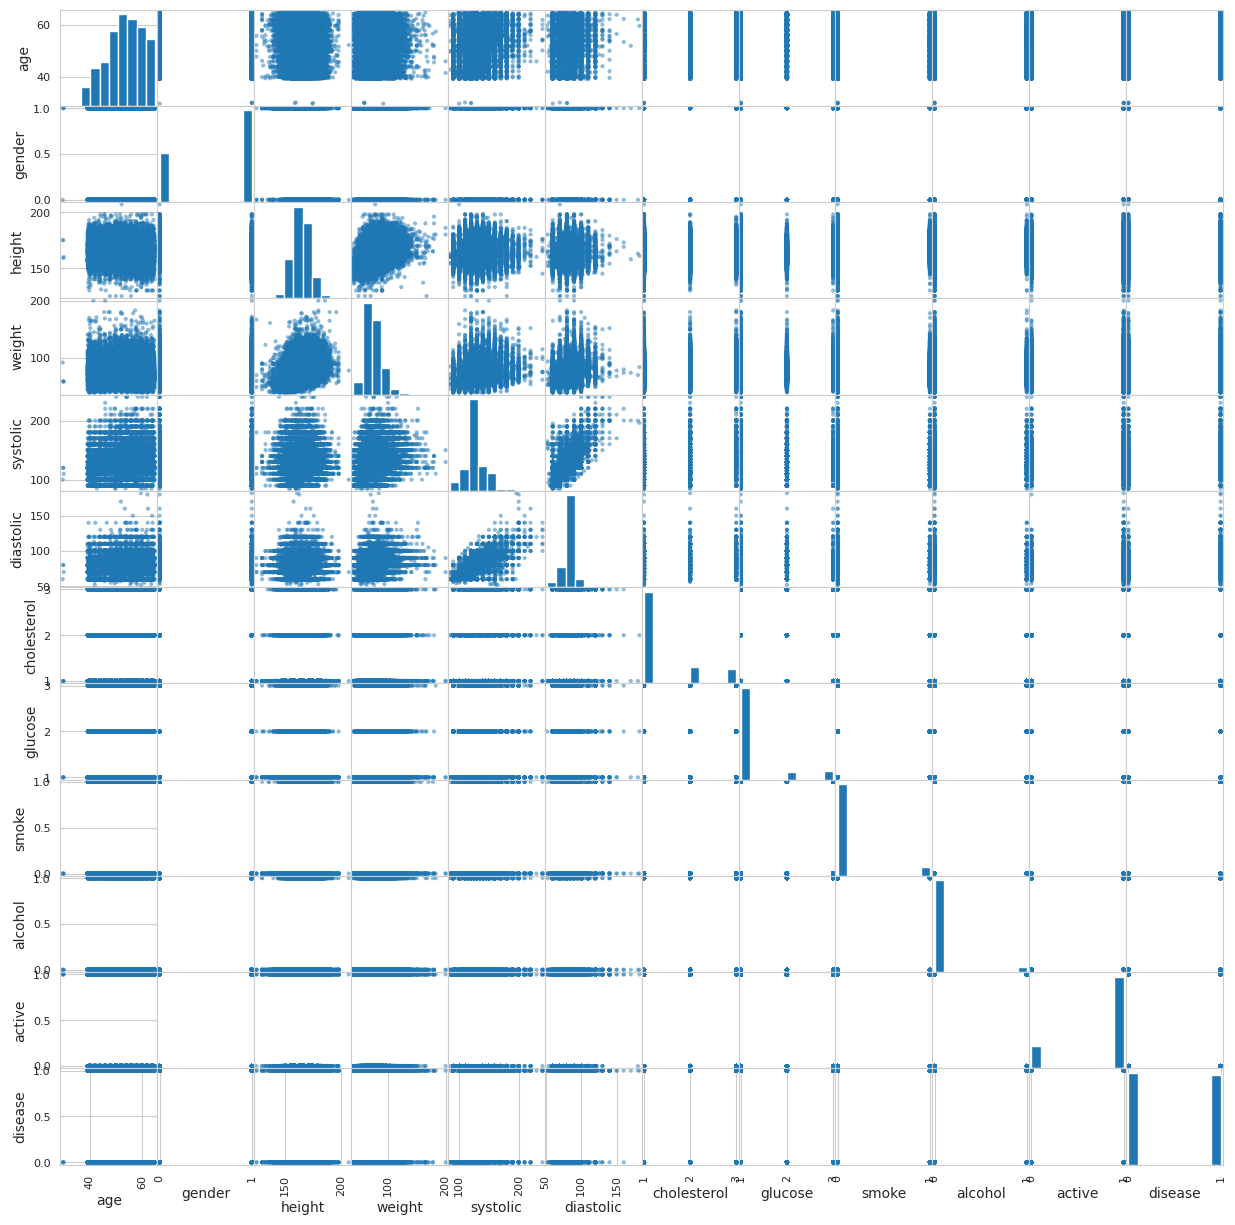

In [10]:
# Cell 7: Explore — scatter matrix for visualization
pd.plotting.scatter_matrix(df, figsize=[15,15])


,count,mean,std,min,25%,50%,75%,max
age,68413.0,53.333130,6.759749,29.60,48.40,54.00,58.40,65.00
gender,68413.0,0.650973,0.476666,0.00,0.00,1.00,1.00,1.00
height,68413.0,164.450835,7.842102,125.00,159.00,165.00,170.00,207.00
weight,68413.0,74.153387,14.259347,40.00,65.00,72.00,82.00,200.00
systolic,68413.0,126.744961,16.620734,85.00,120.00,120.00,140.00,240.00
diastolic,68413.0,81.366188,9.376343,52.00,80.00,80.00,90.00,182.00
cholesterol,68413.0,1.364931,0.679155,1.00,1.00,1.00,2.00,3.00
glucose,68413.0,1.225864,0.571804,1.00,1.00,1.00,1.00,3.00
smoke,68413.0,0.087966,0.283247,0.00,0.00,0.00,0.00,1.00
alcohol,68413.0,0.053396,0.224824,0.00,0.00,0.00,0.00,1.00


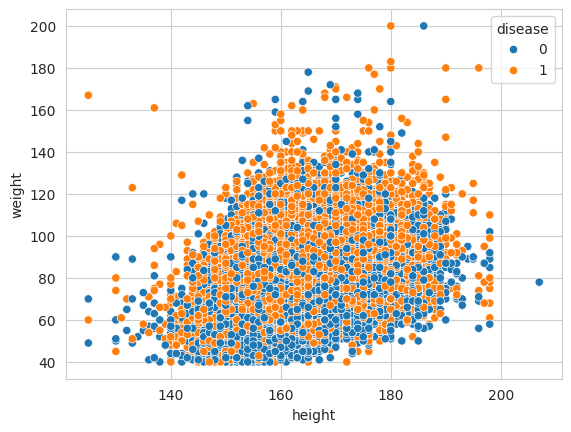

In [11]:
# Cell 8: Explore — BMI analysis
df_eda = df.copy()
sns.scatterplot(x='height', y='weight', hue='disease', data=df_eda)

def BMI(data):
    return round(data['weight'] / (data['height'] / 100) ** 2, 2)

df_eda['BMI'] = df_eda.apply(BMI, axis=1)
df_eda.describe().T


Text(0, 0.5, 'BMI')

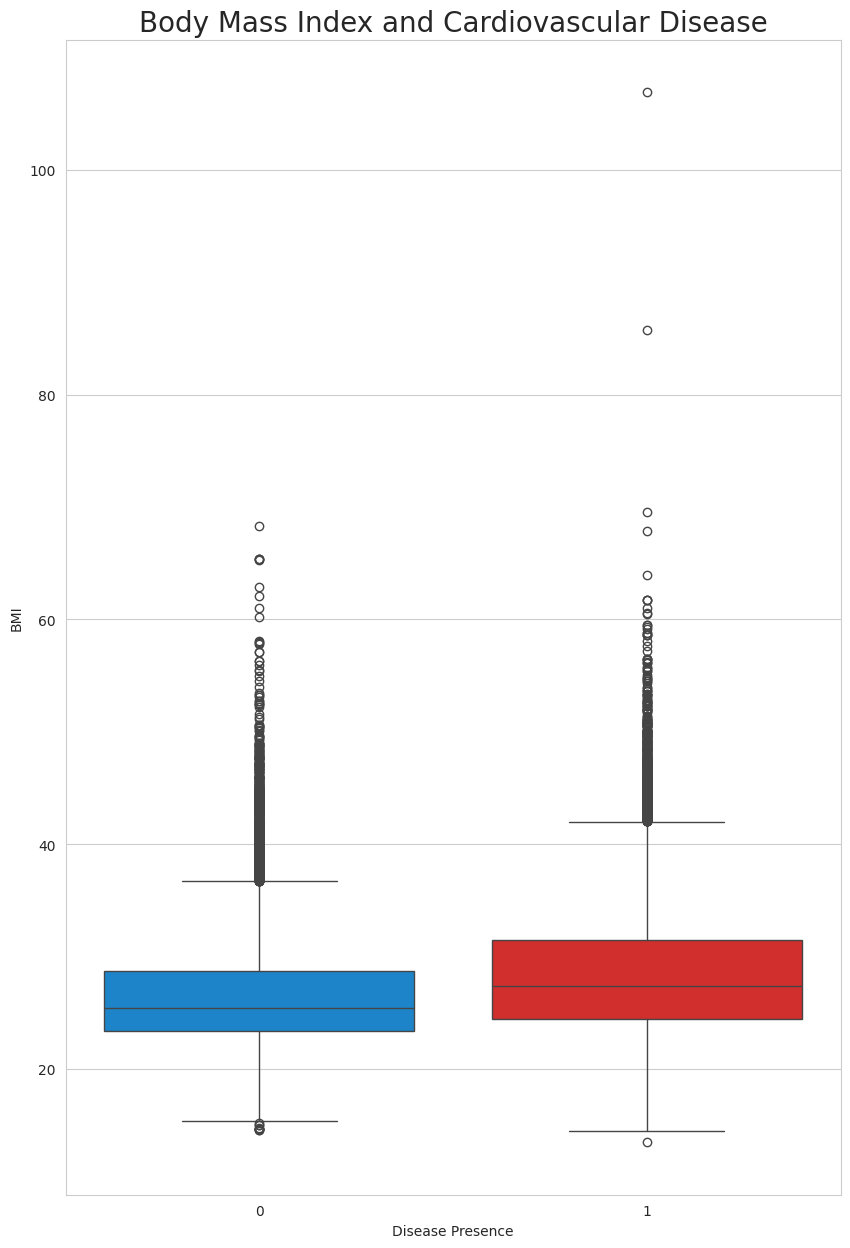

In [12]:
# Cell 9: Explore — BMI boxplot
pal = ['#008ae6','#ec1313']
plt.figure(figsize=(10,15))
sns.boxplot(x='disease', y='BMI', data=df_eda, palette=pal)
plt.title('Body Mass Index and Cardiovascular Disease', fontsize=20)
plt.xlabel('Disease Presence')
plt.ylabel('BMI')


Text(0, 0.5, '# of Patients')

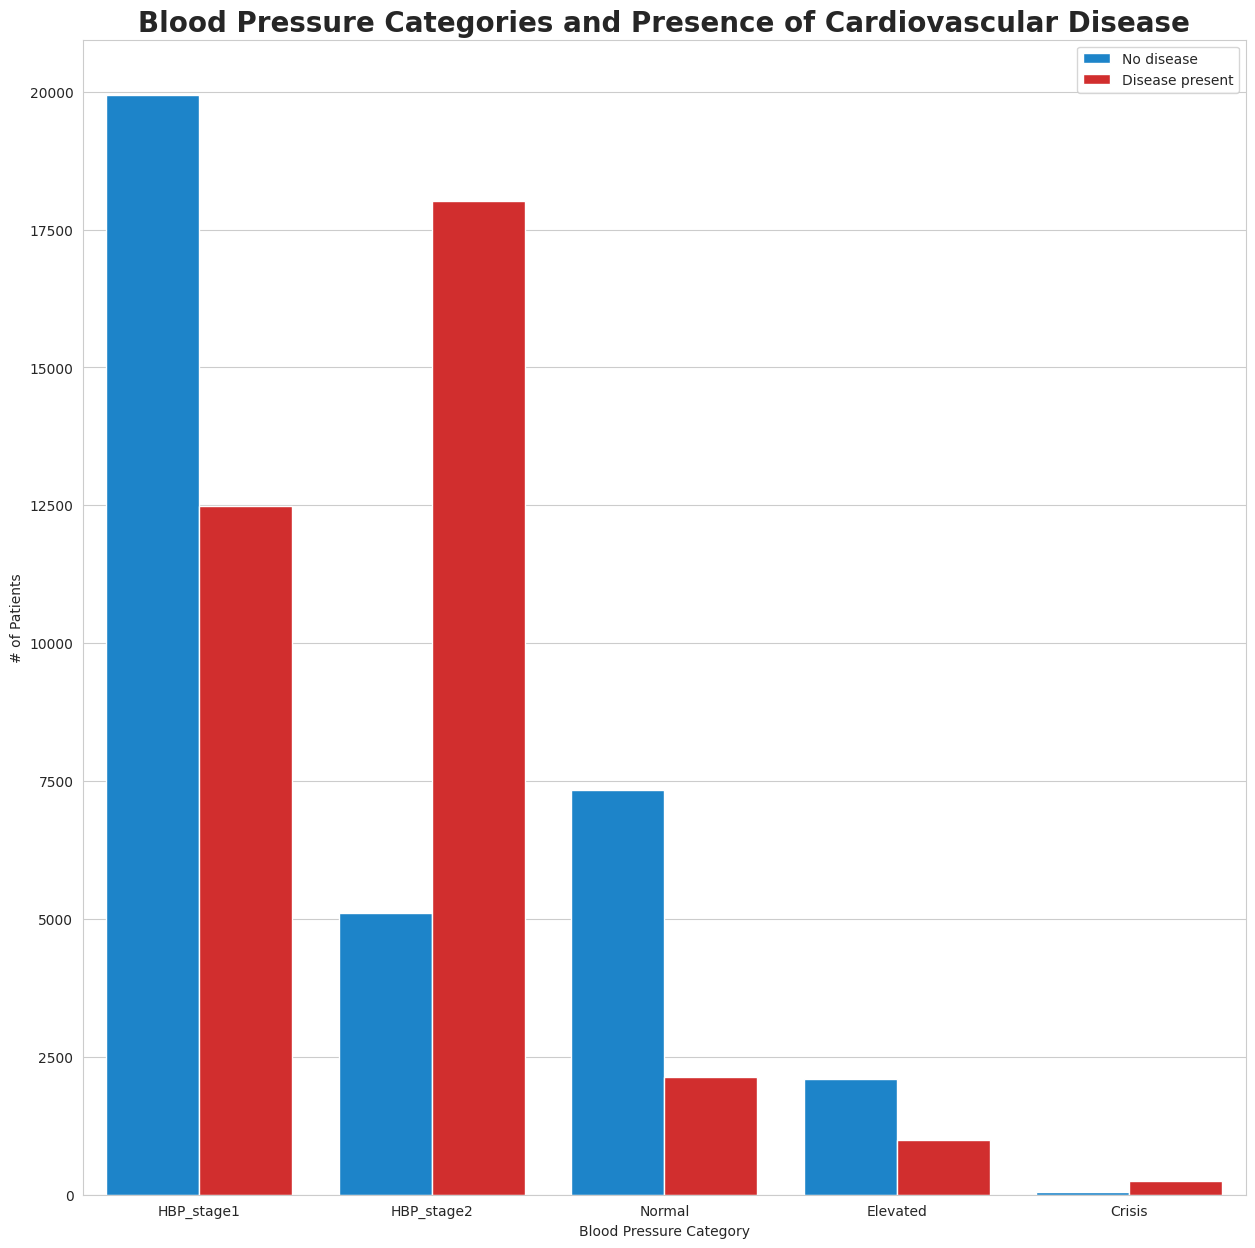

In [13]:
# Cell 10: Explore — blood pressure category analysis
def bp_categories(systolic, diastolic):
    if systolic > 180 or diastolic > 120:
        return 'Crisis'
    elif (140 <= systolic < 180) or (90 <= diastolic < 120):
        return 'HBP_stage2'
    elif (130 <= systolic < 140) or (80 <= diastolic < 90):
        return 'HBP_stage1'
    elif (120 <= systolic < 130) and diastolic < 80:
        return 'Elevated'
    else:
        return 'Normal'

df_eda['HTN_stage'] = df_eda[['systolic','diastolic']].apply(lambda x: bp_categories(*x), axis=1)
df_eda.HTN_stage.value_counts()
pal = ['#008ae6','#ec1313']
plt.figure(figsize=(15,15))
sns.countplot(x='HTN_stage', hue='disease', data=df_eda, palette=pal)
plt.title('Blood Pressure Categories and Presence of Cardiovascular Disease', fontweight='bold', fontsize=20)
plt.xlabel('Blood Pressure Category')
plt.legend(['No disease', 'Disease present'])
plt.ylabel('# of Patients')


29.6 65.0


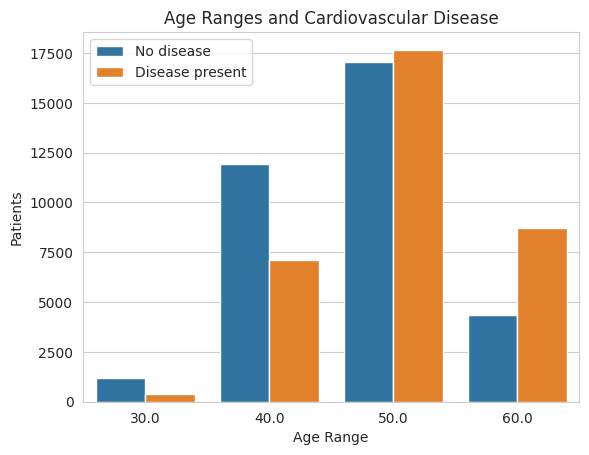

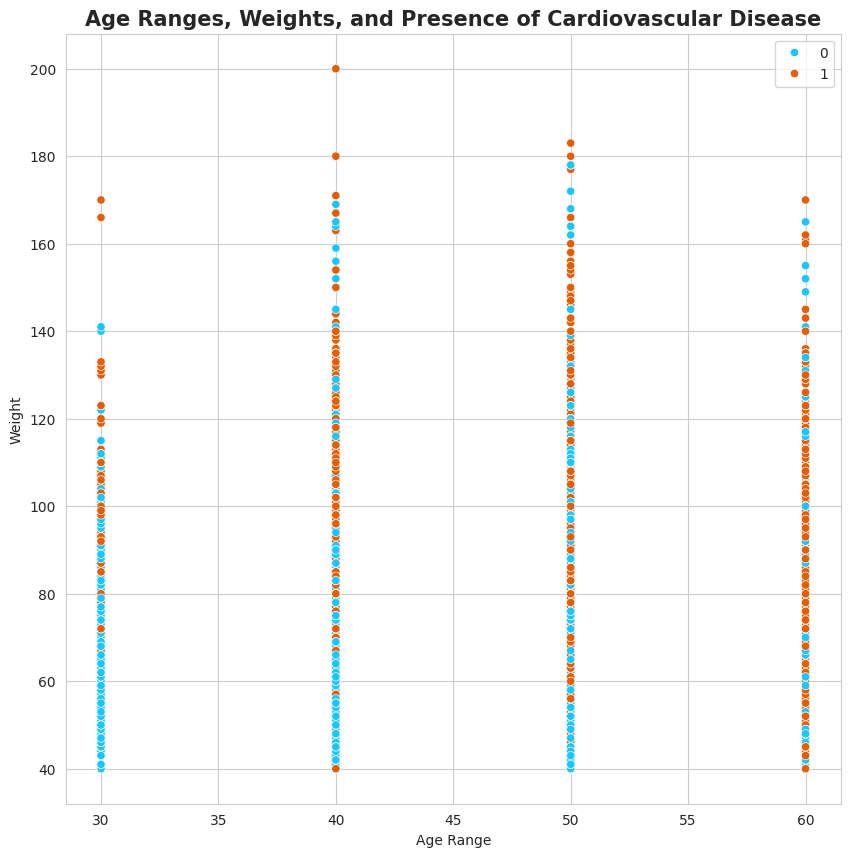

In [14]:
# Cell 11: Explore — age analysis
print(df_eda.age.min(), df_eda.age.max())
df_eda[df_eda['age'] < 30]
df_eda.loc[(df_eda['age'] < 40), 'age_range'] = 30
df_eda.loc[(df_eda['age'] >= 40) & (df_eda['age'] < 50), 'age_range'] = 40
df_eda.loc[(df_eda['age'] >= 50) & (df_eda['age'] < 60), 'age_range'] = 50
df_eda.loc[(df_eda['age'] >= 60) & (df_eda['age'] < 70), 'age_range'] = 60
df_eda.age_range.value_counts(normalize=True)
sns.countplot(x='age_range', hue='disease', data=df_eda)
plt.title('Age Ranges and Cardiovascular Disease')
plt.xlabel('Age Range')
plt.legend(['No disease', 'Disease present'])
plt.ylabel('Patients')

plt.figure(figsize=(10,10))
pal = ['#1ac6ff','#e65c00']
sns.scatterplot(x='age_range', y='weight', hue='disease', data=df_eda, palette=pal)
plt.title('Age Ranges, Weights, and Presence of Cardiovascular Disease', fontweight='bold', fontsize=15)
plt.xlabel('Age Range')
plt.ylabel('Weight')
plt.legend()


,disease
gender,
0,0.499832
1,0.492826


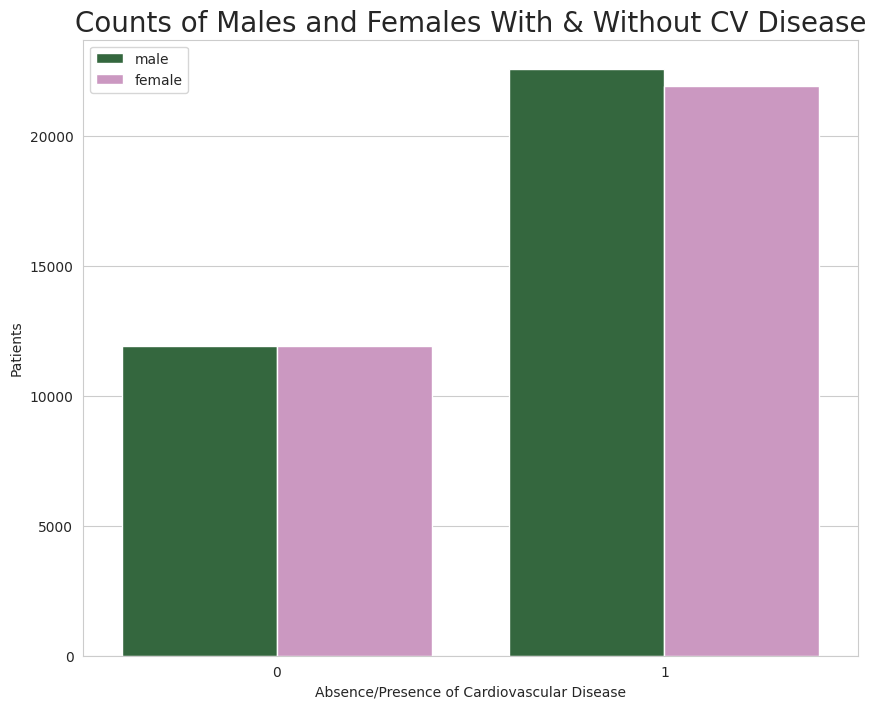

In [15]:
# Cell 12: Explore — gender analysis
df_eda.groupby('gender')['height'].mean()
df_eda.groupby('gender')['weight'].mean()
df_eda.gender.value_counts(normalize=True)

legend_labels = ['male', 'female']
plt.figure(figsize=(10,8))
plt.title('Counts of Males and Females With & Without CV Disease', fontsize=20)
sns.countplot(x='gender', hue='disease', data=df_eda, palette='cubehelix')
plt.xlabel('Absence/Presence of Cardiovascular Disease')
plt.legend(legend_labels)
plt.ylabel('Patients')

df_eda.groupby('gender')['disease'].mean()


,disease
cholesterol,
1,0.435971
2,0.597237
3,0.762420


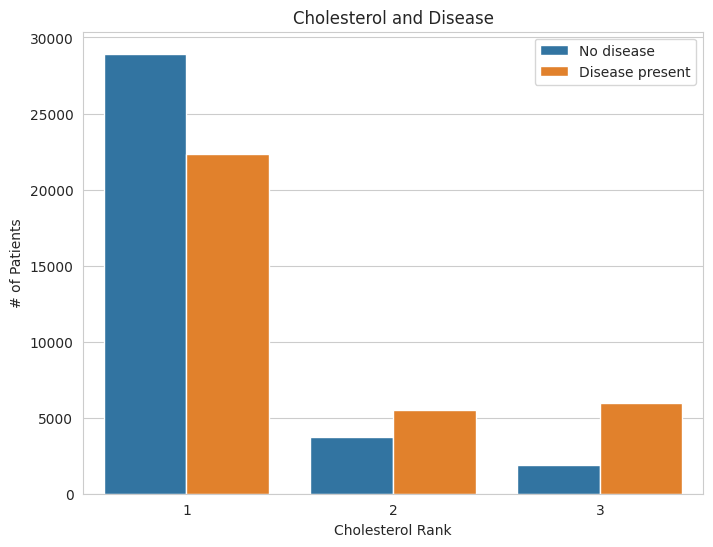

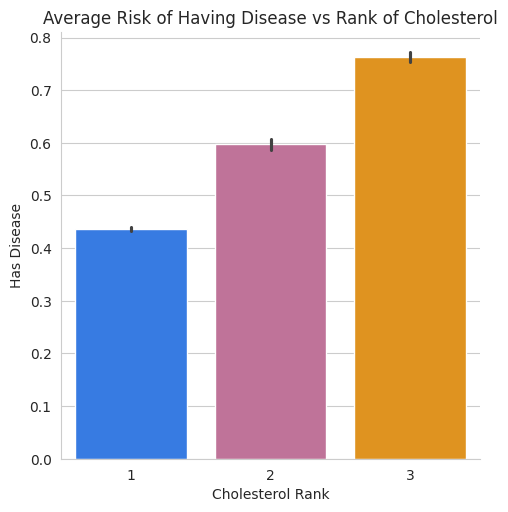

In [16]:
# Cell 13: Explore — cholesterol analysis
df_eda.cholesterol.value_counts(normalize=True)
plt.figure(figsize=(8,6))
sns.countplot(x='cholesterol', hue='disease', data=df_eda)
plt.legend(['No disease', 'Disease present'])
plt.title('Cholesterol and Disease')
plt.xlabel('Cholesterol Rank')
plt.ylabel('# of Patients')

pal = ['#1a75ff','#cc6699','#ff9900']
sns.catplot(x='cholesterol', y='disease', data=df_eda, kind='bar', palette=pal)
plt.title('Average Risk of Having Disease vs Rank of Cholesterol')
plt.xlabel('Cholesterol Rank')
plt.ylabel('Has Disease')

df_eda.groupby('cholesterol')['disease'].mean()


disease  active
0        0         26.521442
         1         26.460297
1        0         28.540764
         1         28.436058
Name: BMI, dtype: float64

<Figure size 1200x1000 with 0 Axes>

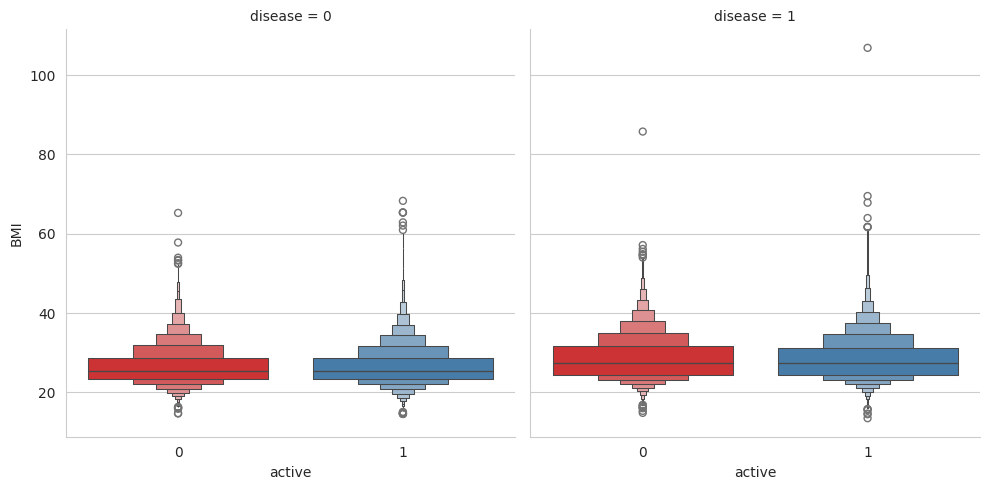

In [17]:
# Cell 14: Explore — activity analysis
df_eda.active.value_counts(normalize=True)
plt.figure(figsize=(12,10))
sns.catplot(x='active', y='BMI', col='disease', data=df_eda, kind='boxen', palette='Set1')
df_eda.groupby(['disease','active'])['BMI'].mean()


,disease
glucose,
1,0.476171
2,0.589378
3,0.617528


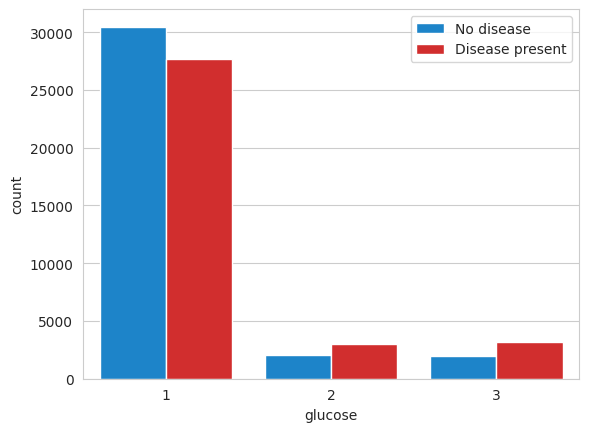

In [18]:
# Cell 15: Explore — glucose analysis
pal = ['#008ae6','#ec1313']
sns.countplot(x='glucose', hue='disease', data=df_eda, palette=pal)
plt.legend(['No disease', 'Disease present'])
df_eda.groupby('glucose')['disease'].mean()


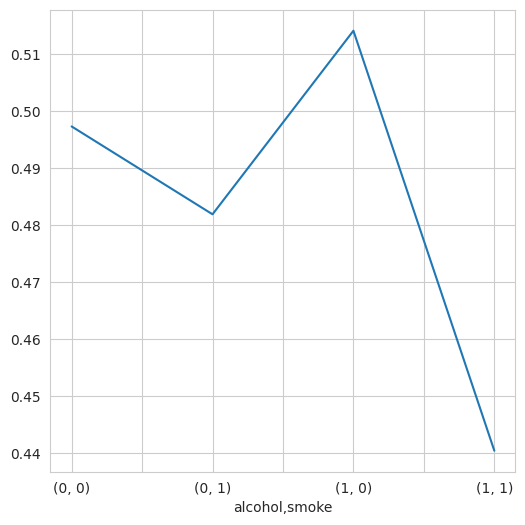

In [19]:
# Cell 16: Explore — alcohol & smoking
df_eda.groupby(['alcohol','smoke'])['disease'].mean()
df_eda.groupby(['alcohol','smoke'])['disease'].count()
fig = plt.figure(figsize=(6,6))
al_smo = df_eda.groupby(['alcohol','smoke'])['disease'].mean().plot()


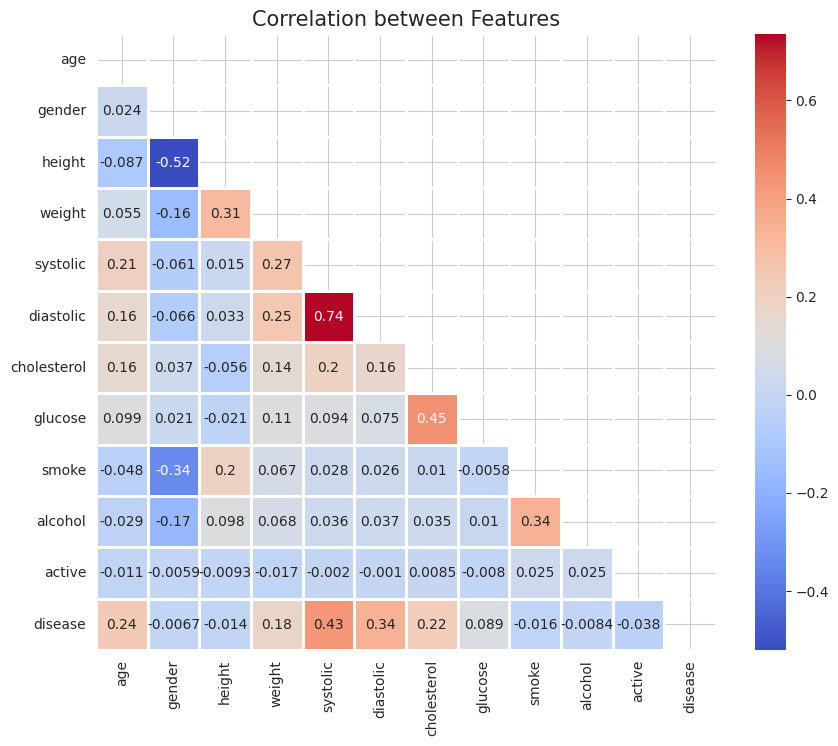

In [20]:
# Cell 17: Explore — heatmap
corr = df.corr()
plt.figure(figsize=(10,8))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(df.corr(), cmap='coolwarm', mask=mask, linewidths=1, annot=True)
plt.title('Correlation between Features', fontsize=15)
plt.show()


In [21]:
# Cell 18: Models — one-hot encode, split, standardize
df['cholesterol'] = df['cholesterol'].astype('category')
df['glucose'] = df['glucose'].astype('category')
df = pd.get_dummies(df, prefix=['chol','gluc'], drop_first=True)
y = df['disease']
X = df.drop('disease', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
y_test.shape
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [22]:
# Cell 19: Models — build and evaluate vanilla classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': XGBClassifier()
}
results = pd.DataFrame(columns=['Train_accuracy','Test_accuracy','F1_score','False_Negative','True_Positive'])
conf_matrices = []

for key, value in classifiers.items():
    value.fit(X_train, y_train)
    train_pred = value.predict(X_train)
    y_pred = value.predict(X_test)
    train_acc = accuracy_score(y_train, train_pred) * 100
    test_acc = accuracy_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    FN = cm[1][0]
    TP = cm[1][1]
    conf_matrices.append(cm)
    results.loc[key] = [round(train_acc,2), round(test_acc,2), round(f1,2), round(FN,0), round(TP,0)]

results.sort_values(by=['F1_score','False_Negative'], ascending=False)


,Train_accuracy,Test_accuracy,F1_score,False_Negative,True_Positive
Logistic Regression,72.83,72.82,0.71,2825.0,5637.0
Support Vector Machine,73.78,73.22,0.71,2790.0,5672.0
XGBoost,76.38,72.81,0.71,2702.0,5760.0
Random Forest,99.55,71.25,0.71,2547.0,5915.0
K-Nearest Neighbors,78.40,69.06,0.69,2695.0,5767.0
Decision Tree,99.55,63.39,0.63,3165.0,5297.0


In [25]:
# Cell 20: Hyperparameter Tuning — function to evaluate models
from sklearn.metrics import ConfusionMatrixDisplay

def get_results(model, model_name):
    train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    print(f'{model_name} Classification Report')
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Blues", values_format='.5g')
    plt.grid(False)
    plt.show()
    train_acc = accuracy_score(y_train, train_pred) * 100
    test_acc = accuracy_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    FN = cm[1][0]
    TP = cm[1][1]
    results.loc[model_name] = [round(train_acc,2), round(test_acc,2), round(f1,2), round(FN,0), round(TP,0)]

RS XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.77      0.62      0.69      8642
           1       0.68      0.81      0.74      8462

    accuracy                           0.72     17104
   macro avg       0.72      0.72      0.71     17104
weighted avg       0.72      0.72      0.71     17104



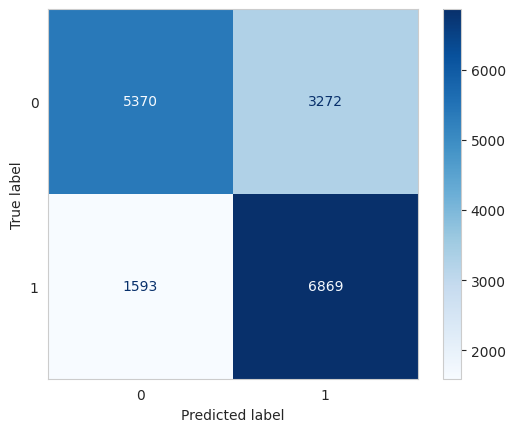

In [26]:
# Cell 21: Hyperparameter Tuning — XGBoost via RandomizedSearchCV
xgb = XGBClassifier()
param_grid_xgb = {
    'learning_rate': [0.08],
    'max_depth': [4],
    'min_child_weight': [2, 3],
    'n_estimaters': [125, 150],
    'scale_pos_weight': [1.5, 1.7]
}
RS_xgb = RandomizedSearchCV(xgb, param_grid_xgb, n_jobs=3, scoring='recall', random_state=42)
RS_xgb.fit(X_train, y_train)
RS_xgb.best_params_
get_results(RS_xgb, 'RS XGBoost')


RS Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.75      0.66      0.71      8642
           1       0.69      0.78      0.73      8462

    accuracy                           0.72     17104
   macro avg       0.72      0.72      0.72     17104
weighted avg       0.72      0.72      0.72     17104



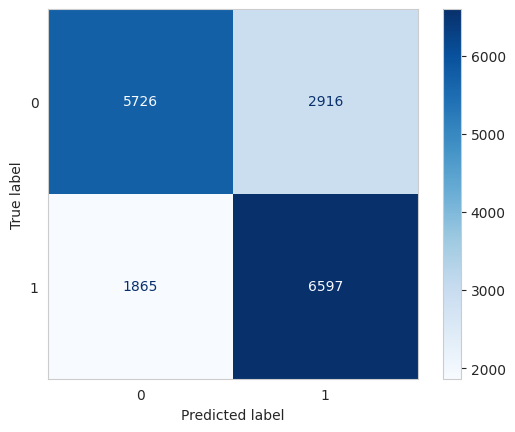

In [27]:
# Cell 22: Hyperparameter Tuning — Random Forest
RF = RandomForestClassifier()
param_grid_RF = {
    'n_estimators': [200],
    'max_depth': [100],
    'min_samples_split': [5, 8],
    'min_samples_leaf': [3],
    'class_weight': [{1: 1.5}, {1: 1.7}]
}
RS_RF = RandomizedSearchCV(RF, param_grid_RF, n_iter=20, scoring='recall', random_state=42)
RS_RF.fit(X_train, y_train)
RS_RF.best_params_
get_results(RS_RF, 'RS Random Forest')


GS KNN Classification Report
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      8642
           1       0.72      0.69      0.71      8462

    accuracy                           0.72     17104
   macro avg       0.72      0.72      0.72     17104
weighted avg       0.72      0.72      0.72     17104



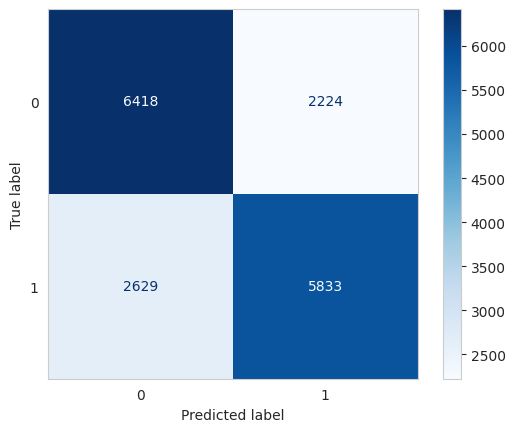

In [28]:
# Cell 23: Hyperparameter Tuning — K-Nearest Neighbors
KNN = KNeighborsClassifier()
param_grid_KNN = {
    'n_neighbors': [23, 25, 27],
    'weights': ['uniform', 'distance']
}
GS_KNN = GridSearchCV(KNN, param_grid_KNN, n_jobs=3, scoring='recall')
GS_KNN.fit(X_train, y_train)
GS_KNN.best_params_
get_results(GS_KNN, 'GS KNN')


Tuned SVM Classification Report
              precision    recall  f1-score   support

           0       0.75      0.67      0.71      8642
           1       0.70      0.78      0.73      8462

    accuracy                           0.72     17104
   macro avg       0.73      0.72      0.72     17104
weighted avg       0.73      0.72      0.72     17104



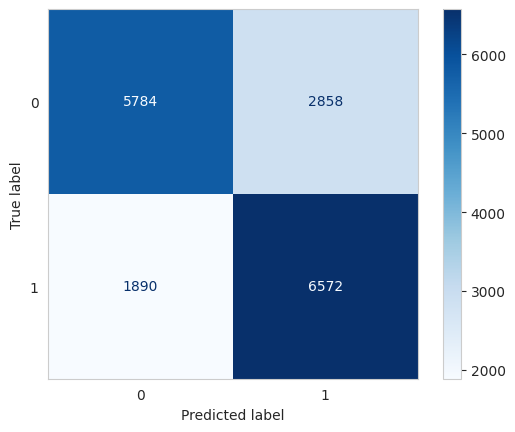

In [29]:
# Cell 24: Hyperparameter Tuning — Support Vector Machines
svc = SVC(class_weight={1:1.5}, random_state=42)
svc.fit(X_train, y_train)
get_results(svc, 'Tuned SVM')


GS Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.76      0.64      0.69      8642
           1       0.68      0.79      0.73      8462

    accuracy                           0.71     17104
   macro avg       0.72      0.71      0.71     17104
weighted avg       0.72      0.71      0.71     17104



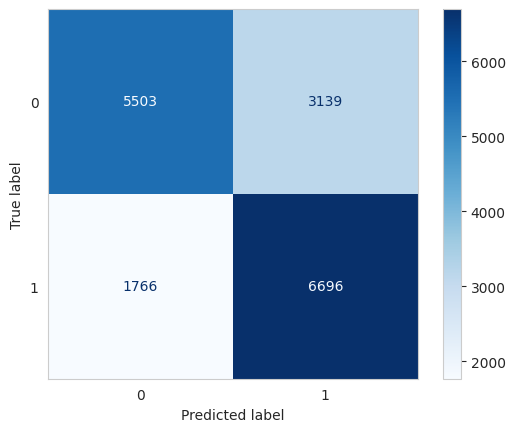

In [30]:
# Cell 25: Hyperparameter Tuning — Logistic Regression
LG = LogisticRegression()
param_grid_LG = {
    'penalty': ['l1', 'l2'],
    'C': [0.05, 0.1, 1],
    'class_weight': [None, {1: 1.5}],
    'random_state': [42]
}
GS_LG = GridSearchCV(LG, param_grid_LG, scoring='recall')
GS_LG.fit(X_train, y_train)
GS_LG.best_params_
get_results(GS_LG, 'GS Logistic Regression')


RS Decision Tree Classification Report
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      8642
           1       0.73      0.73      0.73      8462

    accuracy                           0.73     17104
   macro avg       0.73      0.73      0.73     17104
weighted avg       0.73      0.73      0.73     17104



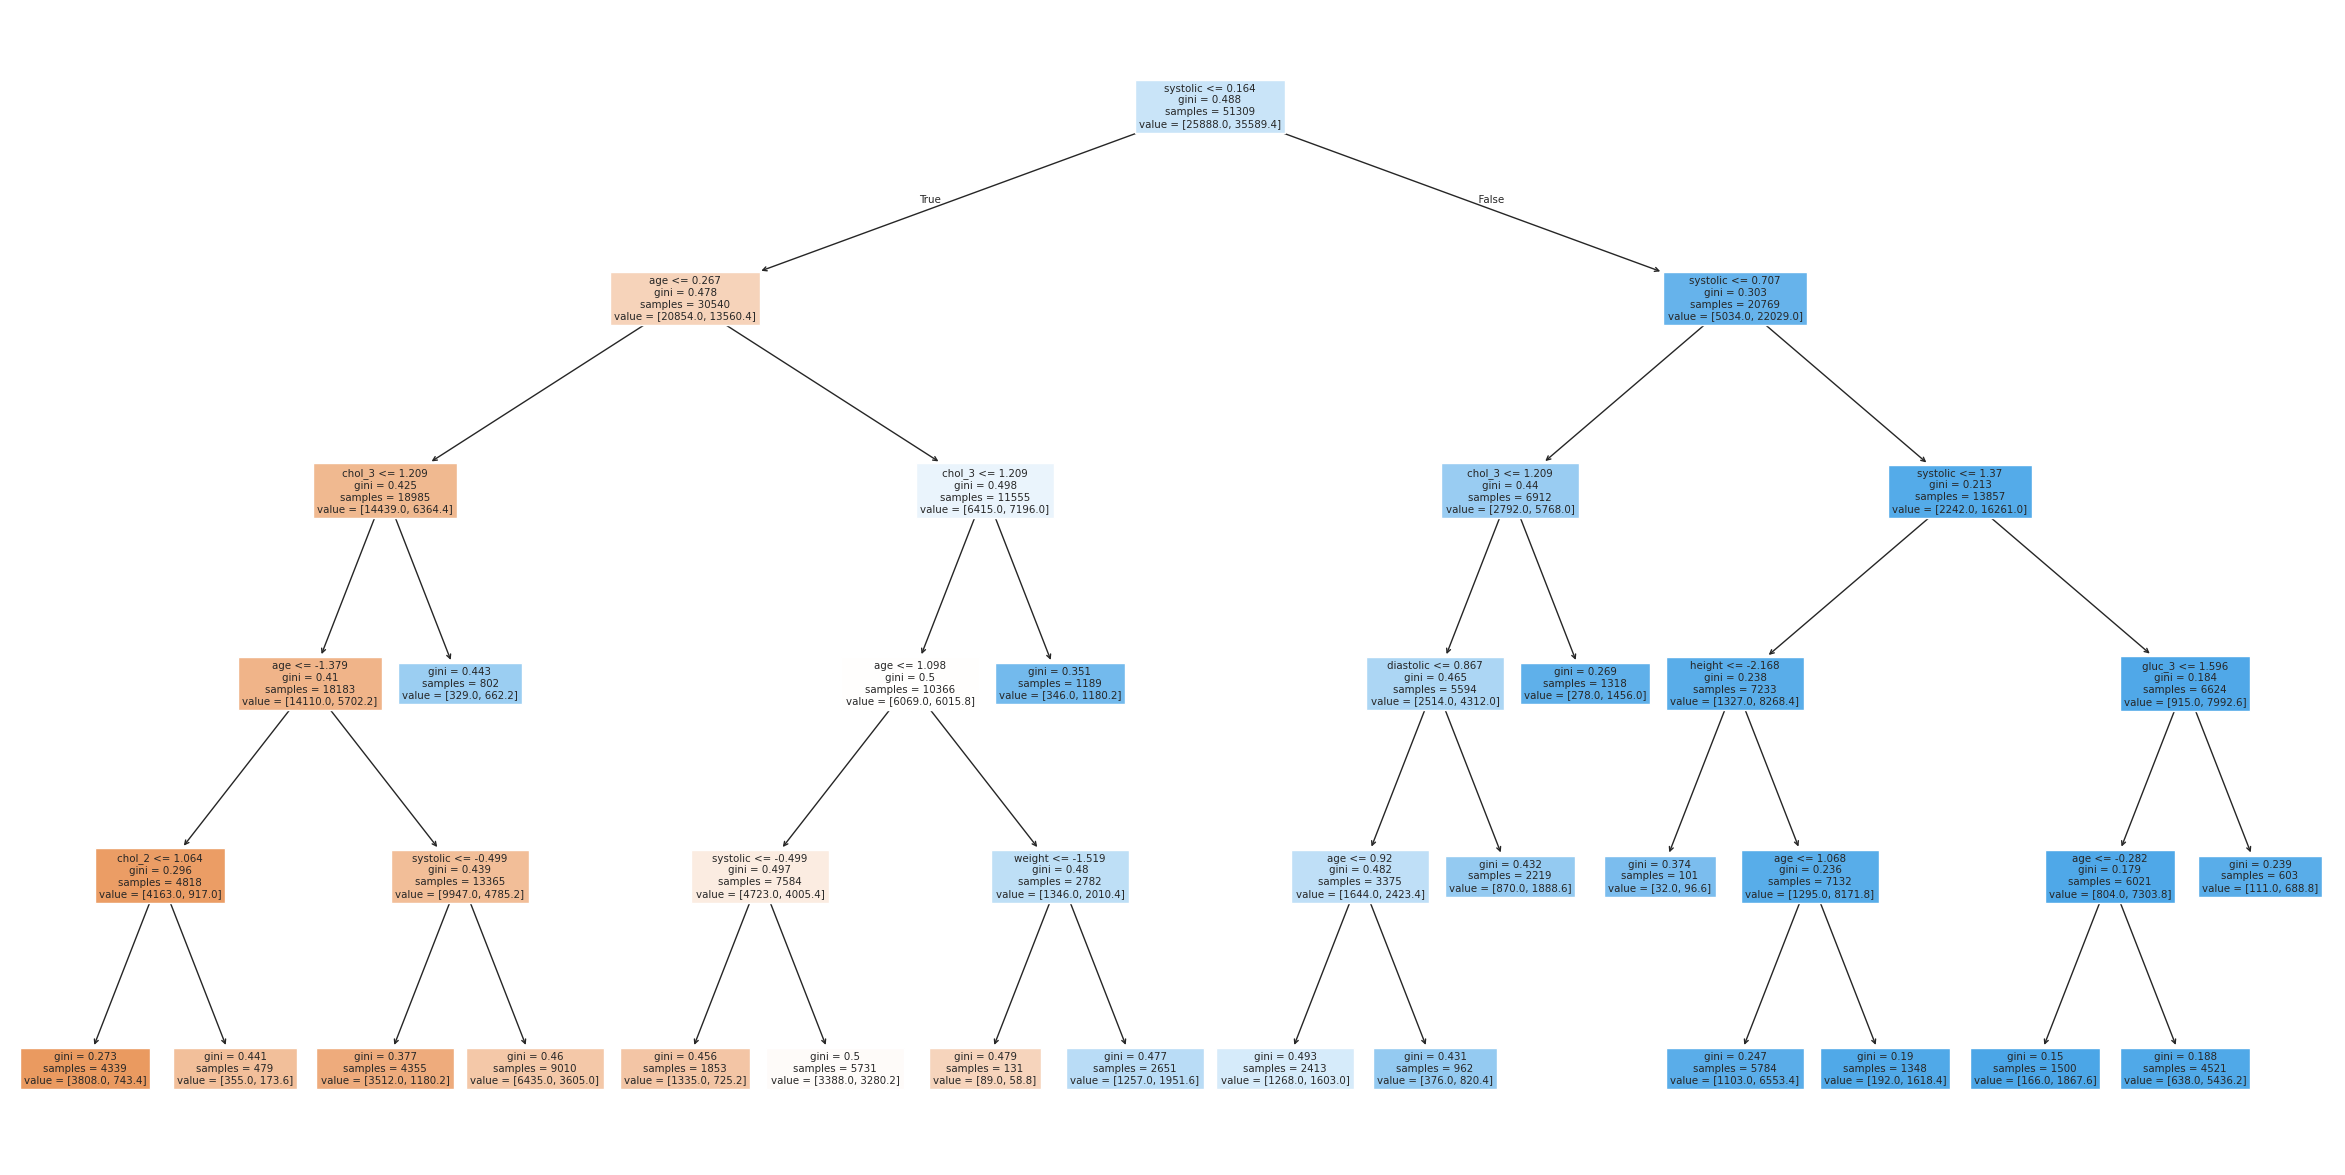

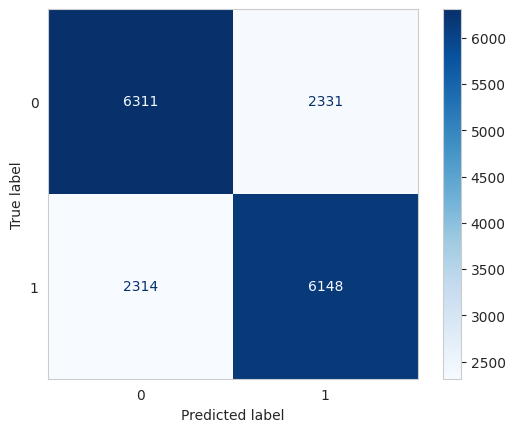

In [31]:
# Cell 26: Hyperparameter Tuning — Decision Tree
DT = DecisionTreeClassifier()
param_grid_DT = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [0.01, 0.05, 0.1],
    'min_samples_leaf': [5, 7],
    'class_weight': [{1: 1.4}, {1: 1.6}]
}
RS_DT = RandomizedSearchCV(DT, param_grid_DT, n_jobs=3, random_state=42)
RS_DT.fit(X_train, y_train)
RS_DT.best_params_

plt.figure(figsize=(30,15))
plot_tree(RS_DT.best_estimator_, feature_names=X.columns, filled=True)

get_results(RS_DT, 'RS Decision Tree')


Extra Tuned XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.83      0.37      0.52      8642
           1       0.59      0.92      0.72      8462

    accuracy                           0.65     17104
   macro avg       0.71      0.65      0.62     17104
weighted avg       0.71      0.65      0.62     17104



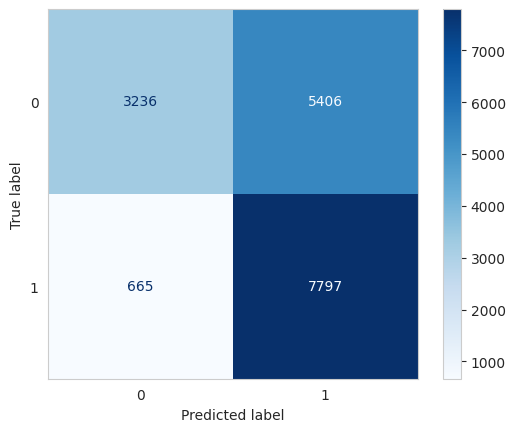

In [32]:
# Cell 27: Hyperparameter Tuning — Extra Tuned XGBoost
xgb2 = XGBClassifier(scale_pos_weight=3, n_estimators=125, min_child_weight=3, max_depth=4, learning_rate=0.08, random_state=42)
xgb2.fit(X_train, y_train)
get_results(xgb2, 'Extra Tuned XGBoost')


In [33]:
# Cell 28: Interpret — view all results
results = results.sort_values(by=['F1_score', 'False_Negative'], ascending=False)
results


,Train_accuracy,Test_accuracy,F1_score,False_Negative,True_Positive
RS XGBoost,72.02,71.56,0.74,1593.0,6869.0
RS Decision Tree,72.83,72.84,0.73,2314.0,6148.0
Tuned SVM,73.02,72.24,0.73,1890.0,6572.0
RS Random Forest,81.84,72.05,0.73,1865.0,6597.0
GS Logistic Regression,71.53,71.32,0.73,1766.0,6696.0
Extra Tuned XGBoost,65.01,64.51,0.72,665.0,7797.0
Logistic Regression,72.83,72.82,0.71,2825.0,5637.0
Support Vector Machine,73.78,73.22,0.71,2790.0,5672.0
XGBoost,76.38,72.81,0.71,2702.0,5760.0
GS KNN,99.55,71.63,0.71,2629.0,5833.0


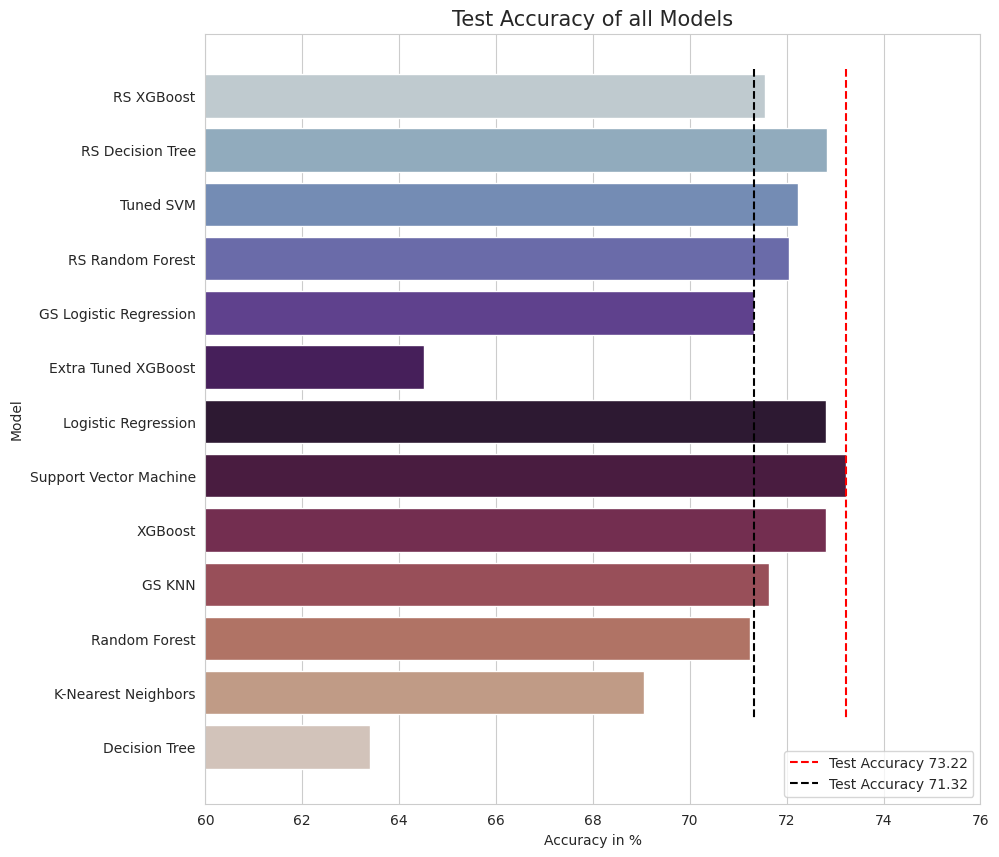

In [34]:
# Cell 29: Interpret — Test accuracy bar graph
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x=results['Test_accuracy'], y=results.index, palette='twilight')
plt.vlines(x=73.22, ymin=-.5, ymax=11.5, linestyle='dashed', color='r', label='Test Accuracy 73.22')
plt.vlines(x=71.32, ymin=-.5, ymax=11.5, linestyle='dashed', color='black', label='Test Accuracy 71.32')
plt.title('Test Accuracy of all Models', fontsize=15)
plt.ylabel('Model')
plt.xlabel('Accuracy in %')
plt.xlim(60, 76)
ax.legend(loc='lower right')


Text(0, 0.5, 'True Positive Rate')

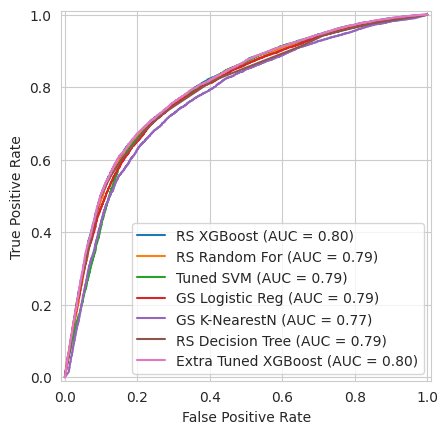

In [36]:
# Cell 30: Interpret — ROC curve comparison
fig = RocCurveDisplay.from_estimator(RS_xgb, X_test, y_test, name='RS XGBoost')
RocCurveDisplay.from_estimator(RS_RF, X_test, y_test, ax=fig.ax_, name='RS Random For')
RocCurveDisplay.from_estimator(svc, X_test, y_test, ax=fig.ax_, name='Tuned SVM')
RocCurveDisplay.from_estimator(GS_LG, X_test, y_test, ax=fig.ax_, name='GS Logistic Reg')
RocCurveDisplay.from_estimator(GS_KNN, X_test, y_test, ax=fig.ax_, name='GS K-NearestN')
RocCurveDisplay.from_estimator(RS_DT, X_test, y_test, ax=fig.ax_, name='RS Decision Tree')
RocCurveDisplay.from_estimator(xgb2, X_test, y_test, ax=fig.ax_, name='Extra Tuned XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

,feature_names,feature_importance
4,systolic,0.583638
10,chol_3,0.137935
0,age,0.071950
8,active,0.035083
5,diastolic,0.032743
9,chol_2,0.027678
6,smoke,0.021073
3,weight,0.020866
7,alcohol,0.016810
12,gluc_3,0.016663


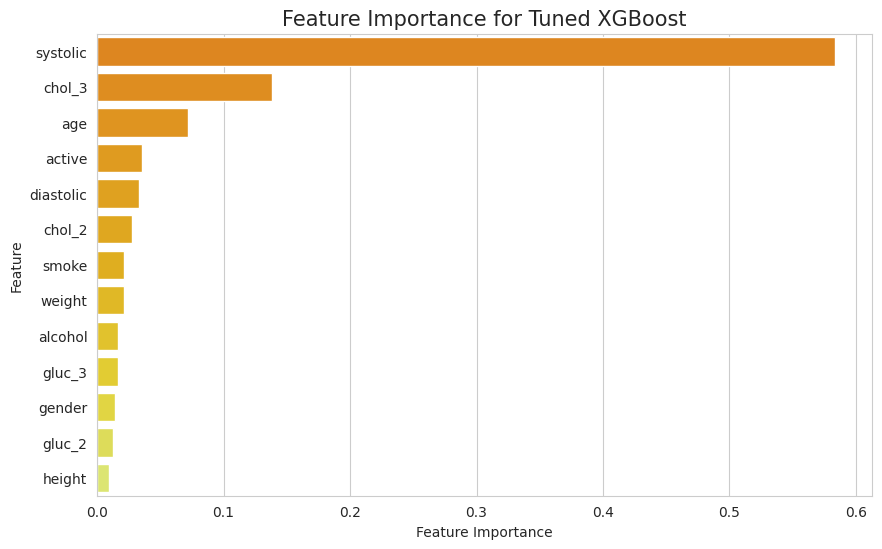

In [37]:
# Cell 31: Interpret — Feature importance for tuned XGBoost
FeatImp = {'feature_names': X.columns.values, 'feature_importance': RS_xgb.best_estimator_.feature_importances_}
FI_df = pd.DataFrame(FeatImp)
FI_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
plt.figure(figsize=(10,6))
sns.barplot(x=FI_df['feature_importance'], y=FI_df['feature_names'], palette='Wistia_r')
plt.title('Feature Importance for Tuned XGBoost', fontsize=15)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
FI_df


In [38]:
import joblib
import os

# Create a directory to save the models if it doesn't exist
if not os.path.exists('tuned_models'):
    os.makedirs('tuned_models')

# Save each fine-tuned model
joblib.dump(RS_xgb, 'tuned_models/RS_XGBoost.pkl')
joblib.dump(RS_RF, 'tuned_models/RS_Random_Forest.pkl')
joblib.dump(GS_KNN, 'tuned_models/GS_KNN.pkl')
joblib.dump(svc, 'tuned_models/Tuned_SVM.pkl')
joblib.dump(GS_LG, 'tuned_models/GS_Logistic_Regression.pkl')
joblib.dump(RS_DT, 'tuned_models/RS_Decision_Tree.pkl')
joblib.dump(xgb2, 'tuned_models/Extra_Tuned_XGBoost.pkl')

print("Fine-tuned models saved to the 'tuned_models' directory.")

Fine-tuned models saved to the 'tuned_models' directory.
